In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from pmagpy import ipmag, pmag

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
from vgptools.auxiliar import (get_files_in_directory, spherical2cartesian, 
                               cartesian2spherical, GCD_cartesian, shape, get_angle, PD, eigen_decomposition)                              
from vgptools.utils_compilation import dfs_vgps_recomputed_poles
from vgptools.utils_APWPs import running_mean_APWP_shape, RM_stats, get_vgps_sampling_from_direction
from vgptools.utils_visualization import  RM_stats, plot_VGPs_and_APWP, plot_APWP_RM_ensemble, quantiles,plot_pole_A95, plot_pole, PC
np.random.seed(10)

## 1. Compile the VGPs 

In [2]:
current_path = os.getcwd()
data_path_VGP = current_path + '/data/vgp_database'

In [3]:
# df_filtered_vgps, df_pole_compilation = dfs_vgps_recomputed_poles(data_path_VGP, by_study = True) # takes as many as poles as are described for one are
df_filtered_vgps = pd.read_csv(current_path +'/data/df_vgps_filtered.csv')

In [36]:
train.head()

,name,fm./loc.,slat,slon,n,dec,inc,k,alpha95,f_corr,VGP_lat,VGP_lon,K,A95,dp,dm,mean_age,min_age,2sig_min,max_age,2sig_max,uncer_dist,rock_typ_1,rock_typ_2,rock_typ_3,demag,struc_cont,rot_area,polarity,strat_group,ordering,synch_unit,in_study_pole,rej_crit,pmag_ref,age_ref,pmag_comments,age_comments,Unnamed: 38,Study,VGP_lon_recalc,VGP_lat_recalc,inc_reverse,dec_reverse,vgp_lat_SH,vgp_lon_SH,age_uncertainty,keep
657,LB11,Little Belt Mountains,46.81000,249.300000,8.0,17.4,67.3,166.6,4.1,NaN,78.0,316.7,NaN,NaN,NaN,NaN,51.600,47.900,NaN,55.3,NaN,uniform,igneous,shallow intrusive,lamprophyre,AF,0.0,0.0,NaN,0.0,NaN,0.0,1,[],Diehl et al. (1983),Marvin et al. (1973); recalculated with new de...,NaN,K-Ar age estimates not re-calculated (from 198...,NaN,N_Montana_intrusions,317.047850,78.034314,-67.3,197.4,-78.034314,137.047850,7.400,True
656,LB10,Little Belt Mountains,46.81000,249.300000,8.0,166.5,-70.4,39.2,7.9,NaN,78.5,206.4,NaN,NaN,NaN,NaN,51.600,47.900,NaN,55.3,NaN,uniform,igneous,shallow intrusive,lamprophyre,AF,0.0,0.0,NaN,0.0,NaN,0.0,1,[],Diehl et al. (1983),Marvin et al. (1973); recalculated with new de...,NaN,K-Ar age estimates not re-calculated (from 198...,NaN,N_Montana_intrusions,26.499519,-78.503396,-70.4,166.5,-78.503396,26.499519,7.400,True
721,7.0,Robinson Anticline Intrusive Complex,46.20000,249.500000,4.0,316.0,56.0,22.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.300,48.000,1.9,52.6,2.0,uniform,igneous,shallow intrusive,syenite sill,AF-TH,1.0,1.0,N,0.0,NaN,0.0,1,[],Harlan et al. (1988),Harlan et al. (1988),Listed directions are in situ because authors ...,Based on min/max K-Ar ages provided by Harlan ...,NaN,Robinson_Antincline_intrusions,158.995345,56.077205,-56.0,136.0,-56.077205,338.995345,4.600,True
428,46.0,Bearwallow Mt.,33.76000,-107.830000,4.0,18.7,44.4,302.2,5.3,NaN,72.1,2.5,NaN,NaN,NaN,NaN,22.500,21.000,NaN,24.0,NaN,uniform,igneous,volcanic,lava flow,AF-TH,1.0,0.0,NaN,0.0,NaN,0.0,1,[],Diehl et al. (1988),Diehl et al. (1988),NaN,Age range as reported in Diehl et al. (1988) [...,NaN,Mogollon-Datil_volcanics,2.581658,72.107020,-44.4,198.7,-72.107020,182.581658,3.000,True
352,Tan11 (NI 18),Tancitaro volcanics,19.01025,-102.067639,7.0,349.3,43.6,189.0,4.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.163,0.126,NaN,0.2,NaN,normal,igneous,volcanic,andesite,AF-TH,1.0,0.0,N,0.0,NaN,0.0,1,[],Maciel Peña et al. (2009),Maciel Peña et al. (2009),NaN,NaN,NaN,Michoacan_Guanajuato_volcanic_field,202.952244,78.188459,-43.6,169.3,-78.188459,22.952244,0.074,True


In [33]:
%%time

min_age = 0
max_age = 65
steps = [5] # [2,5,10] 
window_lengths = [10,15,20,25,30,35,50] # np.arange(10,35,5)

df_ensemble = pd.DataFrame(columns = ['window lenght','n_training','mean_distance','std_distance'])

for step in steps:
    
    for window in window_lengths:

        for i in range(10):

            df_tmp = pd.DataFrame()

            train, test = train_test_split(df_filtered_vgps, test_size=0.4)        

            mean_distances = []
            std_distances = []

            for j in range(10):

                train_ = get_vgps_sampling_from_direction(train)
                test_ = get_vgps_sampling_from_direction(test)
             
                RM_train_ = running_mean_APWP_shape(train_, 'plon', 'plat', 'age', window, step, max_age, min_age)
                RM_test_ = running_mean_APWP_shape(test_, 'plon', 'plat', 'age', window, step, max_age, min_age)            

                distances = []

                for t in RM_train_.age.unique():

                    df_train = RM_train_[RM_train_['age']==t]
                    df_test = RM_test_[RM_test_['age']==t]

                    try:
                        gcd = pmag.angle([df_train['plon'].iat[0], df_train['plat'].iat[0]],
                                         [df_test['plon'].iat[0], df_test['plat'].iat[0]])
                    except:
                        continue
                 
                    distances.append(gcd)

                mean_distances.append(np.array(distances).mean())
                std_distances.append(np.array(distances).std())
            
            df_ensemble.loc[len(df_ensemble)] = [window, i, np.array(mean_distances).mean(), np.array(std_distances).mean()]

df_ensemble.head()

CPU times: user 3min 45s, sys: 646 ms, total: 3min 46s
Wall time: 3min 46s


,window lenght,n_training,mean_distance,std_distance
0,25.0,0.0,2.418932,1.715878
1,25.0,1.0,3.651845,3.011642
2,25.0,2.0,2.247571,1.534114
3,25.0,3.0,1.858393,1.291458
4,25.0,4.0,3.215962,2.387843


<AxesSubplot:xlabel='window lenght', ylabel='std_distance'>

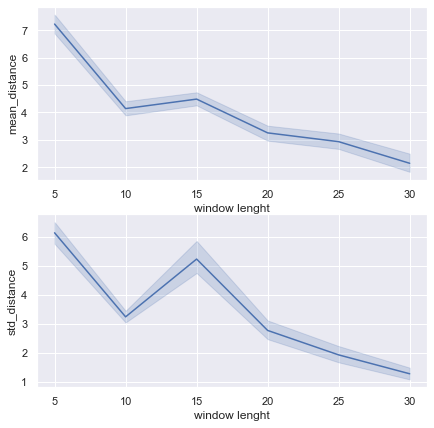

In [32]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(2,1, figsize=(7,7))

sns.lineplot(x="window lenght", y="mean_distance",  
             data=df_ensemble, 
             ax = ax[0], legend = True, palette='GnBu_d')

sns.lineplot(x="window lenght", y="std_distance",
             data=df_ensemble, 
             ax = ax[1], legend = True, palette='GnBu_d')

<AxesSubplot:xlabel='window lenght', ylabel='std_distance'>

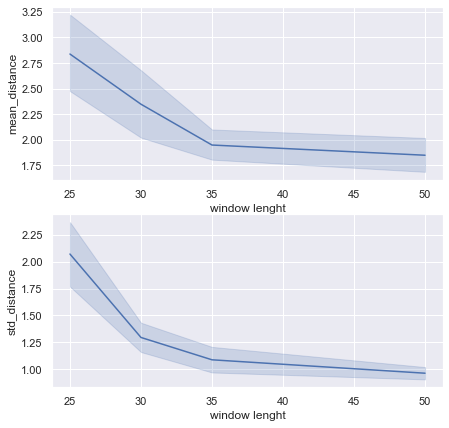

In [34]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(2,1, figsize=(7,7))

sns.lineplot(x="window lenght", y="mean_distance",  
             data=df_ensemble, 
             ax = ax[0], legend = True, palette='GnBu_d')

sns.lineplot(x="window lenght", y="std_distance",
             data=df_ensemble, 
             ax = ax[1], legend = True, palette='GnBu_d')

In [ ]:
%%time

min_age = 0
max_age = 65
steps = [5] # [2,5,10] 
window_lengths = [10,15,20,25,30,35,50] # np.arange(10,35,5)

df_ensemble = pd.DataFrame(columns = ['window lenght','n_training','mean_distance','std_distance'])

for step in steps:
    
    for window in window_lengths:

        for i in range(100):

            df_tmp = pd.DataFrame()

            train, test = train_test_split(df_filtered_vgps, test_size=0.4)        

            mean_distances = []
            std_distances = []

            # train_ = get_vgps_sampling_from_direction(train)
            # test_ = get_vgps_sampling_from_direction(test)

            RM_train_ = running_mean_APWP_shape(train, 'vgp_lon_SH', 'vgp_lat_SH', 'mean_age', window, step, max_age, min_age)
            RM_test_ = running_mean_APWP_shape(test, 'vgp_lon_SH', 'vgp_lat_SH', 'mean_age', window, step, max_age, min_age)            

            distances = []

            for t in RM_train_.age.unique():

                df_train = RM_train_[RM_train_['age']==t]
                df_test = RM_test_[RM_test_['age']==t]

                try:
                    gcd = pmag.angle([df_train['plon'].iat[0], df_train['plat'].iat[0]],
                                     [df_test['plon'].iat[0], df_test['plat'].iat[0]])
                except:
                    continue

                distances.append(gcd)

            mean_distances.append(np.array(distances).mean())
            std_distances.append(np.array(distances).std())
            
            df_ensemble.loc[len(df_ensemble)] = [window, i, np.array(mean_distances).mean(), np.array(std_distances).mean()]

df_ensemble.head()

In [ ]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(2,1, figsize=(7,7))

sns.lineplot(x="window lenght", y="mean_distance",  
             data=df_ensemble, 
             ax = ax[0], legend = True, palette='GnBu_d')

sns.lineplot(x="window lenght", y="std_distance",
             data=df_ensemble, 
             ax = ax[1], legend = True, palette='GnBu_d')